In [1]:
import pandas as pd
import numpy as np

# Load the tab-separated dataset
csv_path = 'marketing_campaign.csv'

# Read as tab-separated (\t)
df = pd.read_csv(csv_path, sep='\t', encoding='utf-8', low_memory=False)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [3]:
# Show the number of people with income over 600,000
high_income_count = (df['Income'] > 600000).sum()
print(f"Number of people with income over $600,000: {high_income_count}")

# Also show these high income rows if any exist
if high_income_count > 0:
    print("\nHigh income rows:")
    print(df[df['Income'] > 600000][['Income', 'Education', 'Marital_Status']])

Number of people with income over $600,000: 1

High income rows:
        Income   Education Marital_Status
2233  666666.0  Graduation       Together


In [4]:
# change 'Alone', 'Absurd', and 'YOLO' values of Marital_Status to 'Single'
df['Marital_Status'] = df['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')

# Remove stagnant features 
df = df.drop(['Z_CostContact', 'Z_Revenue'], axis=1)

In [5]:
# Remove high income outlier first, then fill missing Incomevalues with group means

# Remove the high income outlier first (keep rows with Income <= 600k)
df = df[~(df['Income'] > 600000)]

# Now fill missing Income values with group means (Education + Marital_Status)
df['Income'] = df['Income'].fillna(df.groupby(['Education', 'Marital_Status'])['Income'].transform('mean'))

In [6]:
# Data prep for K-means clustering

# 1. Handle the date column - convert to datetime and extract useful features
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

# Optional: create features from date (days since enrollment, etc.)
# For now, we'll drop it since it's not directly usable in clustering
df_kmeans = df.drop(['ID', 'Dt_Customer'], axis=1).copy()

# 2. Handle categorical variables (Education, Marital_Status)
from sklearn.preprocessing import StandardScaler

# Use one-hot encoding for categorical variables
df_kmeans = pd.get_dummies(df_kmeans, columns=['Education', 'Marital_Status'], prefix=['Education', 'Marital_Status'])

print("One-hot encoded features created:")
education_cols = [col for col in df_kmeans.columns if col.startswith('Education_')]
marital_cols = [col for col in df_kmeans.columns if col.startswith('Marital_Status_')]
print(f"Education features: {education_cols}")
print(f"Marital_Status features: {marital_cols}")

# 3. Scale all features (critical for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans)

print(f"\nData ready for K-means:")
print(f"Shape: {X_scaled.shape}")
print(f"Features: {df_kmeans.columns.tolist()}")
print(f"All numeric, scaled, no missing values: {pd.DataFrame(X_scaled).isna().sum().sum() == 0}")

One-hot encoded features created:
Education features: ['Education_2n Cycle', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD']
Marital_Status features: ['Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Together', 'Marital_Status_Widow']

Data ready for K-means:
Shape: (2239, 33)
Features: ['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Education_2n Cycle', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Together', 'Marital_Status_Widow']
All numeric, scaled, no missing value

K-means Results (k=3):
Silhouette Score: 0.1093
Davies-Bouldin Score: 2.6371
Calinski-Harabasz Score: 295.59

Cluster sizes:
0    1007
1     558
2     674
Name: count, dtype: int64
Cluster ordering by median income (low to high):
Cluster 0: median income $34,230
Cluster 1: median income $58,207
Cluster 2: median income $76,786

Cluster profiles (mean values):
                  Income  MntWines  MntFruits  MntMeatProducts  \
kmeans_cluster                                                   
0               34337.82     38.60       4.85            22.56   
1               58094.00    443.53      22.94           133.45   
2               76406.00    614.69      69.11           468.26   

                MntFishProducts  Recency  
kmeans_cluster                            
0                          6.94    49.14  
1                         30.91    48.63  
2                        100.77    49.67  


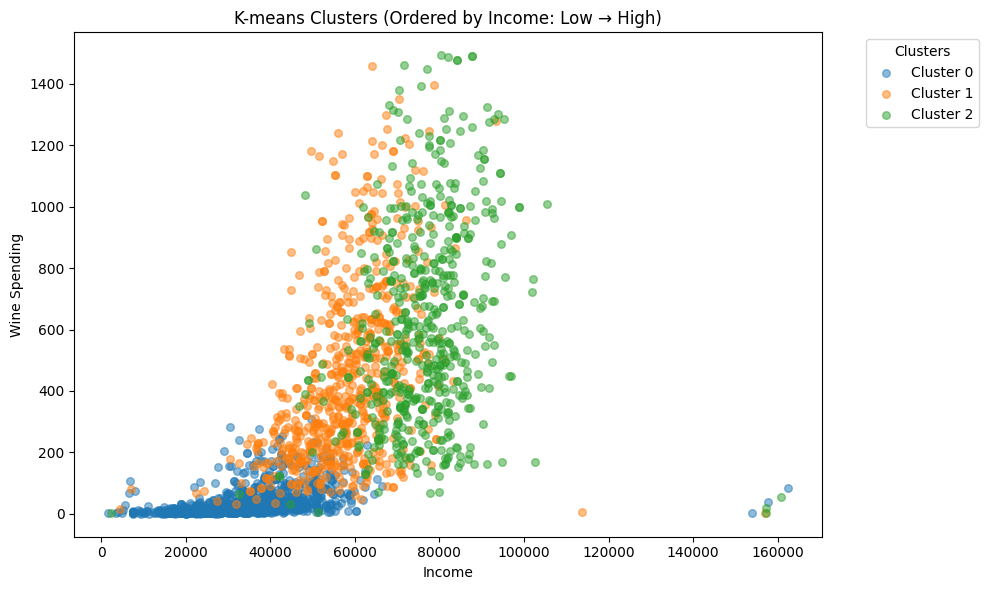

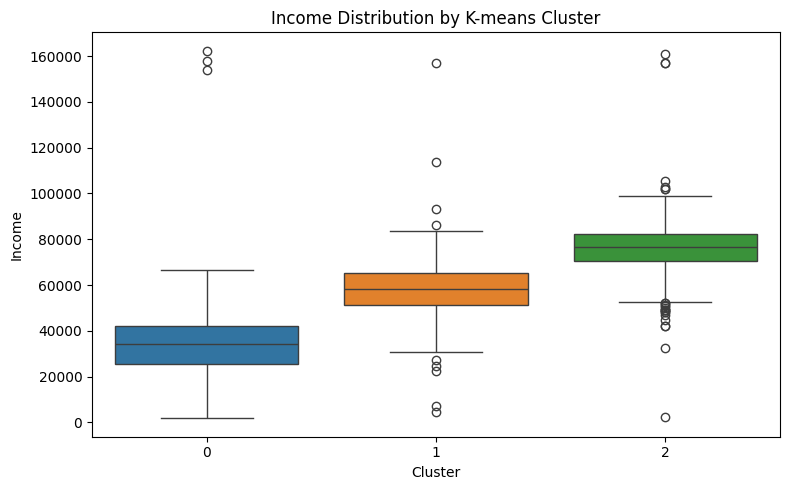

In [7]:
# K-means Base Model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Fit K-means with k=3 (common starting point)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# 2. Calculate clustering metrics
silhouette = silhouette_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, cluster_labels)

print(f"K-means Results (k={k}):")
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f}")

# 3. Cluster size distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nCluster sizes:")
print(cluster_counts)

# 4. Order clusters by median income (left to right on graph)
# Calculate median income for each cluster
cluster_income_medians = df.groupby(cluster_labels)['Income'].median().sort_values()
# Create mapping: lowest income cluster becomes 0, highest becomes 2
income_order_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_income_medians.index)}
# Apply the mapping
cluster_labels_ordered = np.array([income_order_mapping[label] for label in cluster_labels])

df['kmeans_cluster'] = cluster_labels_ordered

print("Cluster ordering by median income (low to high):")
for new_id, old_id in enumerate(cluster_income_medians.index):
    print(f"Cluster {new_id}: median income ${cluster_income_medians[old_id]:,.0f}")

# 5. Analyze clusters by key features
print("\nCluster profiles (mean values):")
key_features = ['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'Recency']
cluster_profiles = df.groupby('kmeans_cluster')[key_features].mean()
print(cluster_profiles.round(2))

# 6. Visualization: Plot clusters using Income vs MntWines (two important features)
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # distinct colors for clusters
for i in range(k):
    cluster_mask = cluster_labels_ordered == i
    plt.scatter(df[cluster_mask]['Income'], df[cluster_mask]['MntWines'], 
                c=colors[i], label=f'Cluster {i}', alpha=0.5, s=30)

plt.xlabel('Income')
plt.ylabel('Wine Spending')
plt.title('K-means Clusters (Ordered by Income: Low → High)')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 7. Box plot of Income by cluster (using same colors as scatter plot)
plt.figure(figsize=(8, 5))
cluster_colors = [colors[i] for i in range(k)]
sns.boxplot(data=df, x='kmeans_cluster', y='Income', hue='kmeans_cluster', palette=cluster_colors, legend=False)
plt.title('Income Distribution by K-means Cluster')
plt.xlabel('Cluster')
plt.ylabel('Income')
plt.tight_layout()
plt.show()